<a href="https://colab.research.google.com/github/Abhijit-Dixit/SPM_Proect/blob/main/Bitcoin_Volatility_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Forecasting BTC-USD Realized Volatility 

Volatility can either be historical or implied; both are usually expressed on an annualized basis in percentage terms. 

- **Historical Volatility** (HV) or **Realized Volatility** is the actual volatility demonstrated by the underlying over a period of time, such as the past month or year. 
- **Implied volatility** (IV), on the other hand, is the level of volatility of the underlying that is implied by the current option price. 

(source: https://www.investopedia.com/articles/investing/021716/strategies-trading-volatility-options-nflx.asp)

The fundamental equation in option trading is:

$P/L = Vega|\sigma_{implied} - \sigma_{realized}|$

in which Vega measures an option’s price sensitivity, or the price change of an option for every 1% change in volatility of the underlying.

If we can identify situations where the above volatility mismatch occurs, there's potential Profit or Loss that can be captured.

(source: **Positional Option Trading: An Advanced Guide** by Euan Sinclair)

The purpose of this project is to forecast one variable of the above equation: the **realized volatility** based on historical/past data using time series analysis. The basic idea we want to describe here is the average forward-looking realized volatility of BTC-USD (returns or log returns of close price of BTC-USD of the next few days as estimated at the end of time step `t`).

“Volatility does **not** measure the direction of price changes, merely their dispersion. This is because when calculating standard deviation (or variance), all differences are squared, so that negative and positive differences are combined into one quantity. Two instruments with different volatilities may have the same expected return, but the instrument with higher volatility will have larger swings in values over a given period of time.”
(source: Wikipedia)

### Challenges

Although the forecasting and modeling of volatility has been the focus of many empirical studies and theoretical investigations in academia, forecasting volatility accurately remains a crucial challenge for scholars. In addition, Crypto options trading is relatively new, there has not been too much research on the topic. There would be certain nuances to crypto that need to be accounted for in this project.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install arch

In [ ]:
!pip3 install yfinance

In [ ]:
import yfinance as yf

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse, r2_score 
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR RESULT DISPLAY LATER)

pd.set_option('display.max_colwidth', None)

In [ ]:
start = datetime(2014, 1, 1)
end = datetime.today()

tckr = 'BTC-USD'

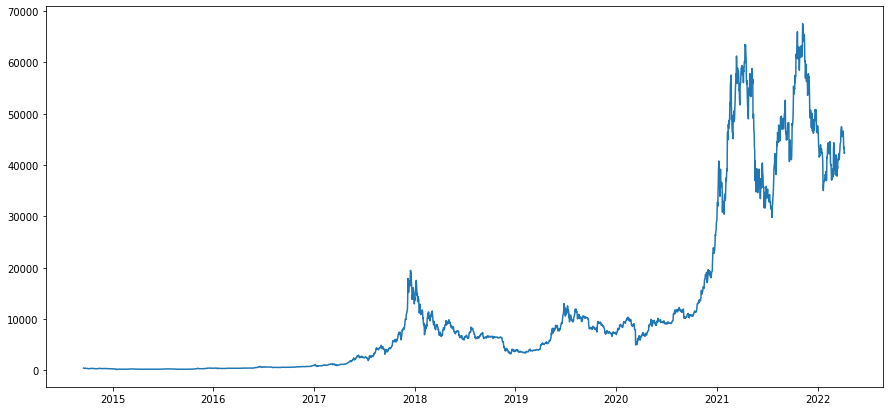

In [ ]:
ticker = yf.Ticker(tckr)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

plt.figure(figsize=(15,7))
plt.plot(df.Close);

Volatility is calculated as the standard deviation of price returns, which is the dollar change in price as a percentage of previous day's price.

In [ ]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

Further research indicates that for practicality purposes it's preferable to use the log returns especially in modeling, because it helps eliminate non-stationary properties of time series data, and makes it more stable.


LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

There's another advantage to log returns, which is that they're additive across time: $r_{t1, t2} + r_{t2, t3} = r_{t1, t3}$


In [ ]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [ ]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns
Date,,,,,,,,,
2022-04-05,46624.507812,47106.140625,45544.808594,45555.992188,29640604055,0,0,-2.287907,-0.023145
2022-04-06,45544.355469,45544.355469,43193.953125,43206.738281,39393395788,0,0,-5.156849,-0.052946
2022-04-07,43207.500000,43860.699219,42899.906250,43503.847656,26101973106,0,0,0.687646,0.006853
2022-04-08,43505.136719,43903.019531,42183.289062,42287.664062,27215995394,0,0,-2.795577,-0.028354
2022-04-09,42366.214844,42602.468750,42189.343750,42454.140625,27112914944,0,0,0.393676,0.003929


In [ ]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns
Date,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0,-7.192558,-0.074643
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0,-6.984265,-0.072402
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0,3.573492,0.035111
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0,-2.465854,-0.024968


In [ ]:
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

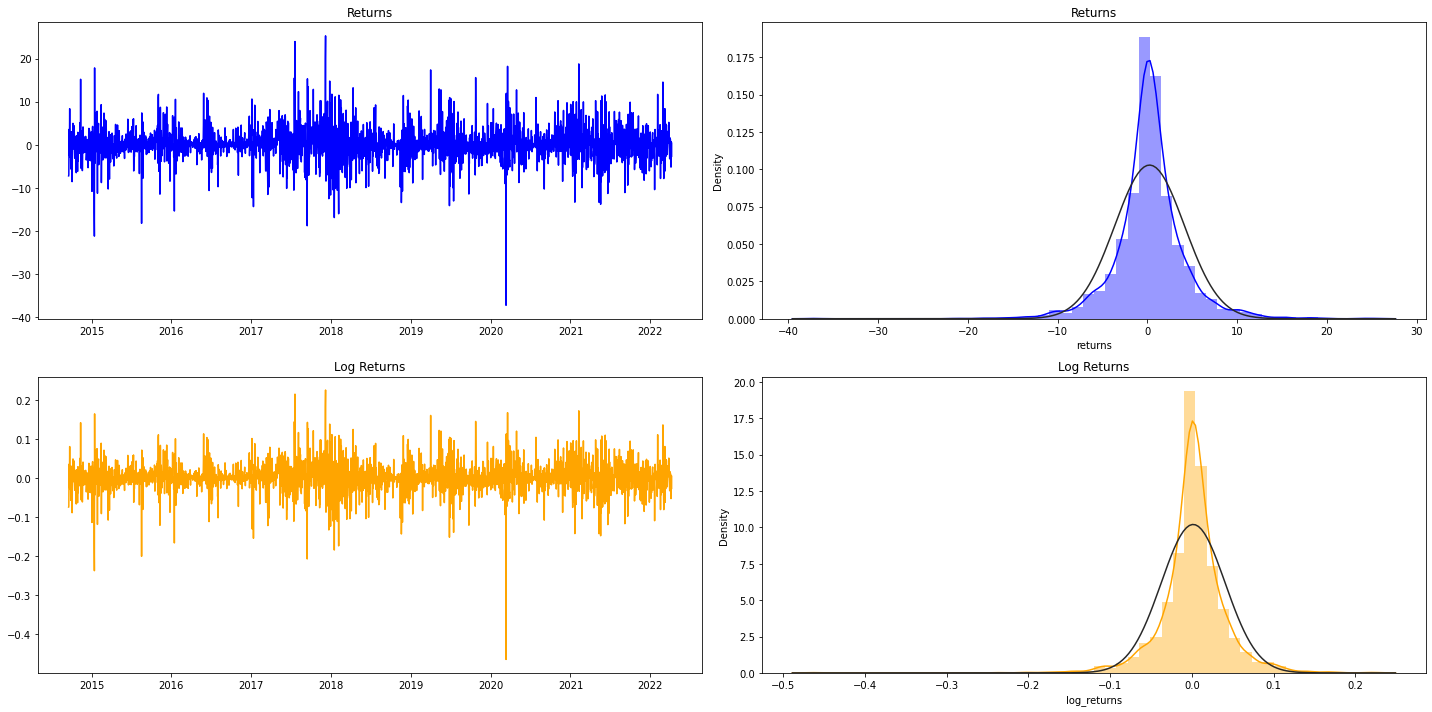

In [ ]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

axes[0][0].plot(df.returns, color='blue')
axes[0][0].set_title('Returns')

sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
             bins=50, ax=axes[0][1])
axes[0][1].set_title('Returns')

axes[1][0].plot(df.log_returns, color='orange')
axes[1][0].set_title('Log Returns')

sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=axes[1][1])
axes[1][1].set_title('Log Returns')
plt.tight_layout()
fig.show();

In [ ]:
df.returns.describe()

count    2761.000000
mean        0.240149
std         3.879325
min       -37.169539
25%        -1.315601
50%         0.200057
75%         1.824908
max        25.247169
Name: returns, dtype: float64

In [ ]:
df.log_returns.describe()

count    2761.000000
mean        0.001641
std         0.039104
min        -0.464730
25%        -0.013243
50%         0.001999
75%         0.018085
max         0.225119
Name: log_returns, dtype: float64

Both Returns & Log Returns show some:
- slight negative skewness
- positive kurtosis (leptokurtic) - higher peak with thick tails than the standard normal distribution.


(Source: https://www.investopedia.com/articles/investing/102715/computing-historical-volatility-excel.asp)

The standard deviation will be different for log returns computed over longer or shorter intervals. For this specific project, the volatility would be for a certain fixed window interval (`WINDOW_SIZE`) is the standard deviation of log returns, or the square root of the sum of squares of log returns:

$\sigma_{interval} = \sqrt{\sum_{t} r_{t-1, t}^2}$

And then to scale the daily volatility by a certain frequency (weekly, monthly, yearly), we can multiply the daily volatility by the square root of that frequency in terms of day divided by the interval minus 1 (`WINDOW_SIZE-1`). For example:

$\sigma_{daily} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{1}{interval-1}}$

$\sigma_{annualized} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{365}{interval-1}}$

$\sigma_{monthly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{30}{interval-1}}$

$\sigma_{weekly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{7}{interval-1}}$


In [ ]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    return np.sqrt(np.sum(series_log_return**2)/(WINDOW_SIZE-1))

For this specific project I'll experiment with an interval window of 30 days (equivalent to roughly 1 month of trading for cryptocurrencies). The goal here is to forecast the average realized volatility of the next `n_future` 7 days using a number of immediate past/historical datapoints (`n_past`). 

The reason I selected 30 days is because 7 days seems too short to observe meaningful patterns, and longer intervals seem to smooth the volatility down significantly. 

In [ ]:
WINDOW_SIZE = 30
n_future = 7

In [ ]:
# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=WINDOW_SIZE)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=WINDOW_SIZE)\
                                 .apply(realized_volatility_daily)

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns,vol_current,vol_future
count,2761.000000,2761.000000,2761.000000,2761.000000,2.761000e+03,2761.0,2761.0,2761.000000,2761.000000,2732.000000,2725.000000
mean,11856.527811,12171.335538,11511.247565,11870.029569,1.493495e+10,0.0,0.0,0.240149,0.001641,0.036225,0.036227
std,16470.217632,16904.675747,15974.805899,16475.094836,1.993086e+10,0.0,0.0,3.879325,0.039104,0.016584,0.016605
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,0.0,0.0,-37.169539,-0.464730,0.007228,0.007228
25%,610.218018,613.814026,607.937988,610.435974,8.235700e+07,0.0,0.0,-1.315601,-0.013243,0.025162,0.025139
50%,6398.850098,6521.990234,6310.109863,6404.000000,5.287530e+09,0.0,0.0,0.200057,0.001999,0.034151,0.034116
75%,10821.632812,11095.870117,10528.890625,10844.640625,2.536519e+10,0.0,0.0,1.824908,0.018085,0.044918,0.044948
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0,25.247169,0.225119,0.103878,0.103878


### Stationarity Checking

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -15.840512625948948
p-value: 9.704936729822796e-29
Critical Values:
1%: -3.4327
5%: -2.8626
10%: -2.5673


In [ ]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -53.57363009241833
p-value: 0.0
Critical Values:
1%: -3.4327
5%: -2.8626
10%: -2.5673


In [ ]:
# CURRENT REALIZED VOLATILITY
adfuller_results = adfuller(df.vol_current.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -5.86818148324128
p-value: 3.287586995253233e-07
Critical Values:
1%: -3.4328
5%: -2.8626
10%: -2.5673


Using a significant level alpha of 0.05, `p-value` is significantly smaller than alpha, which means there's enough evidence to reject the Null Hypothesis. 

--> Returns, Log returns, and Current Volatility are all not dependent on time/trend

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2761 entries, 2014-09-18 to 2022-04-09
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2761 non-null   float64
 1   High          2761 non-null   float64
 2   Low           2761 non-null   float64
 3   Close         2761 non-null   float64
 4   Volume        2761 non-null   int64  
 5   Dividends     2761 non-null   int64  
 6   Stock Splits  2761 non-null   int64  
 7   returns       2761 non-null   float64
 8   log_returns   2761 non-null   float64
 9   vol_current   2732 non-null   float64
 10  vol_future    2725 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 258.8 KB


In [ ]:
df.head(40)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns,vol_current,vol_future
Date,,,,,,,,,,,
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0,-7.192558,-0.074643,NaN,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0,-6.984265,-0.072402,NaN,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0,3.573492,0.035111,NaN,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0,-2.465854,-0.024968,NaN,NaN
2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600,0,0,0.835210,0.008317,NaN,NaN
2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500,0,0,8.364742,0.080333,NaN,NaN
2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700,0,0,-2.888081,-0.029306,NaN,NaN
2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400,0,0,-2.748309,-0.027868,NaN,NaN
2014-09-26,411.428986,414.937988,400.009003,404.424988,21460800,0,0,-1.736994,-0.017523,NaN,NaN


Since I am currently using a `WINDOW_SIZE` of 30 and a horizon `n_future` of  7, the volatilty of first 29 values as well as the last 7 values of the dataframe would be `NaN`, and therefore need to be dropped from the dataset.

In [ ]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

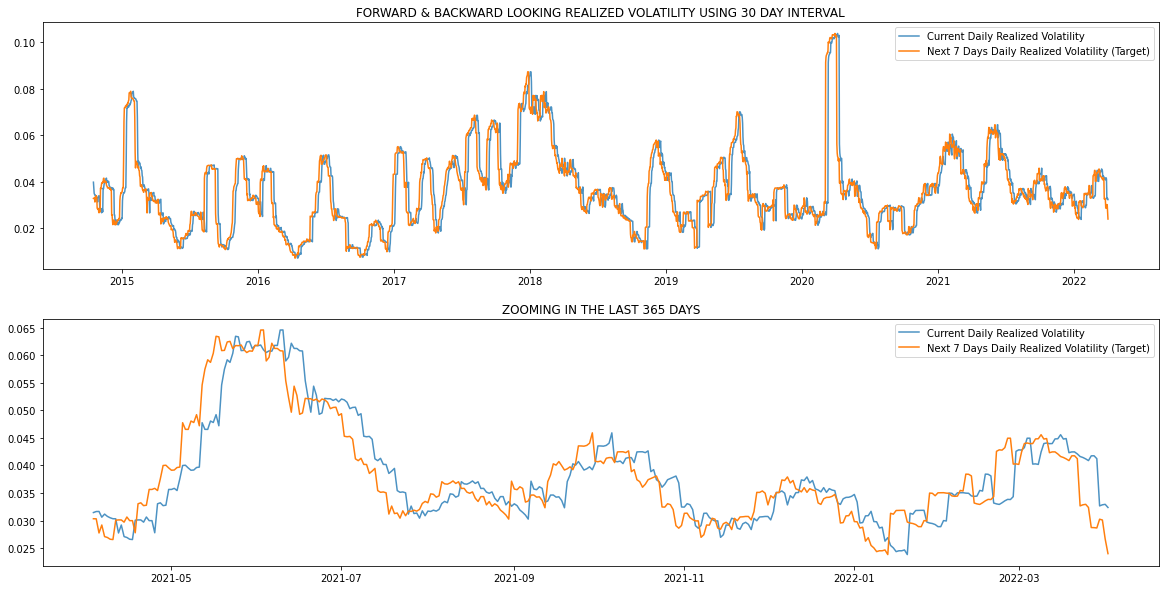

In [ ]:
# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

# ax1.plot(df.log_returns, color='gray', alpha=.4, label='Log Returns')
ax1.plot(df.vol_current, alpha=.8, label='Current Daily Realized Volatility')
ax1.plot(df.vol_future, label=f'Next {n_future} Days Daily Realized Volatility (Target)')

# ax2.plot(df.log_returns[-365:], color='gray', alpha=.4, label='Log Returns')
ax2.plot(df.vol_current[-365:], alpha=.8, label='Current Daily Realized Volatility')
ax2.plot(df.vol_future[-365:], label=f'Next {n_future} Days Daily Realized Volatility (Target)')

ax1.title.set_text(f'FORWARD & BACKWARD LOOKING REALIZED VOLATILITY USING {WINDOW_SIZE} DAY INTERVAL')
ax2.title.set_text('ZOOMING IN THE LAST 365 DAYS')

ax1.legend()
ax2.legend()
plt.show();

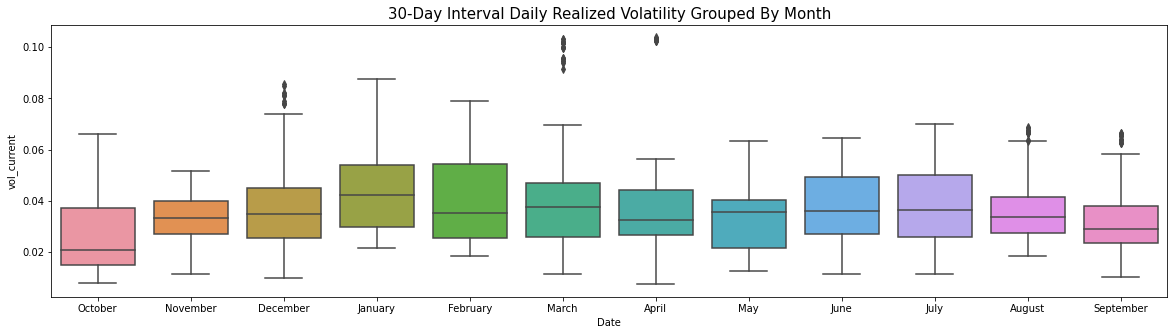

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x=df.index.month_name(), y=df.vol_current, ax=ax)
ax.set_title(f'{WINDOW_SIZE}-Day Interval Daily Realized Volatility Grouped By Month', fontsize=15);

Here we can see that the volatility usually fluctuates within a widest range in the months of December and January. March has the most amount of large outliers, while August and Septermber historically has been relatively quiet.

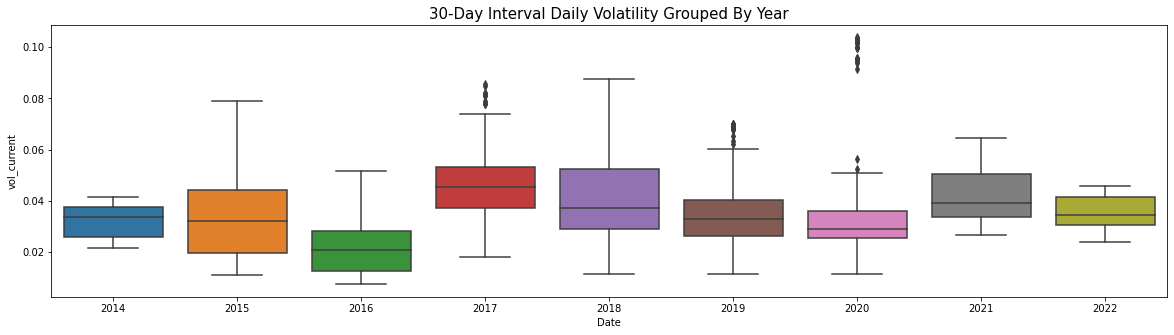

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x=df.index.year, y=df.vol_current, ax=ax)
ax.set_title(f'{WINDOW_SIZE}-Day Interval Daily Volatility Grouped By Year', fontsize=15);

This plot does reflect Bitcoin's first record peak in 2017. And the outliers in 2020 corresponded with the surge in 2020. And based on this, 2021's daily volatiliy overall has been on the higher side as well. 

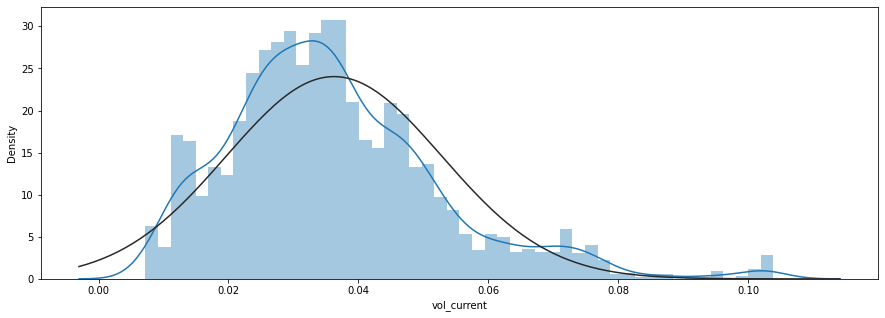

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
             bins=50, ax=ax)
plt.show();

The distribution of daily realized volatility is lightly right skewed, with a small number of larger values spreaded thinly on the right.

A skewed right distribution would have smaller median compared to mean, and mode smaller than median (mode < median < mean).

In [ ]:
len(df)

2725

In [ ]:
df.index

DatetimeIndex(['2014-10-17', '2014-10-18', '2014-10-19', '2014-10-20',
               '2014-10-21', '2014-10-22', '2014-10-23', '2014-10-24',
               '2014-10-25', '2014-10-26',
               ...
               '2022-03-24', '2022-03-25', '2022-03-26', '2022-03-27',
               '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31',
               '2022-04-01', '2022-04-02'],
              dtype='datetime64[ns]', name='Date', length=2725, freq=None)

In [ ]:
100 - 1.2 - 14.7

84.1

### Train-Validation-Test Split

There're a total of 2490 usable datapoints in this dataset which covers a period of almost 7 years from October 2014 until today (August 2021). Since cryptocurrencies are not traded on a regulated exchange, the Bitcoin market is open 24/7, 1 year covers a whole 365 trading days instead of 252 days a year like with other stocks and commodities.

I would split the dataset into 3 parts as follows:
- the most recent 30 usable datapoints would be used for testing - approx. 1.2%
- 1 full year (365 days) for validation - approx. 14.7%
- and the remaining for training - approx. 84.1%




In [ ]:
test_size = 30
val_size = 365

split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [ ]:
print(f'Training \tFrom: {train_idx[0]} \tto {train_idx[-1]} \t{len(train_idx)} days')
print(f'Validation \tFrom: {val_idx[0]} \tto {val_idx[-1]} \t{len(val_idx)} days')
print(f'Test \t\tFrom: {test_idx[0]} \tto {test_idx[-1]} \t{len(test_idx)} days')

Training 	From: 2014-10-17 00:00:00 	to 2021-03-03 00:00:00 	2330 days
Validation 	From: 2021-03-04 00:00:00 	to 2022-03-03 00:00:00 	365 days
Test 		From: 2022-03-04 00:00:00 	to 2022-04-02 00:00:00 	30 days


In [ ]:
# train_idx

In [ ]:
# len(train_idx)

In [ ]:
# val_idx

In [ ]:
# len(val_idx)

In [ ]:
# test_idx

In [ ]:
# len(test_idx)

The target here would be `df['vol_future']` which represents the daily realized volatility of the next `n_future` days from today (average daily volatility from `t + n_future - WINDOW_SIZE` to time step `t + n_future`). 

For example, using an `n_future` value of 7 and a `WINDOW_SIZE` of 30, the value that I want to predict at time step `t` would be the average daily realized volatility from time step `t-23` to time step `t+7`.

In [ ]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [ ]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for some models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [ ]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [ ]:
# SPLIT LOG RETURNS INTO 3 PARTS
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

As I am going to build various types of models based on different algorithms  with slightly different assumptions using different types of parameters, it's probably better to normalize the volatilities using `MinMaxScaler` to standardize performance comparison among different models.

In [ ]:
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT REALIZED VOLATILITY IN TRAINING
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [ ]:
# TRANSFORM TRAINING VOLATILITIES 
x_train_scaled = pd.Series(scaler_vol.transform(x_train.values.reshape(-1,1))[:,0],
                           index=train_idx)
y_train_scaled = pd.Series(scaler_vol.transform(y_train.values.reshape(-1,1))[:,0],
                           index=train_idx)

# TRANSFORMING VALIDATION VOLATILITIES
x_val_scaled = pd.Series(scaler_vol.transform(x_val.values.reshape(-1,1))[:,0],
                           index=val_idx)
y_val_scaled = pd.Series(scaler_vol.transform(y_val.values.reshape(-1,1))[:,0],
                           index=val_idx)

# TRANSFORMING TEST VOLATILITIES
x_test_scaled = pd.Series(scaler_vol.transform(x_test.values.reshape(-1,1))[:,0],
                           index=test_idx)
y_test_scaled = pd.Series(scaler_vol.transform(y_test.values.reshape(-1,1))[:,0],
                           index=test_idx)

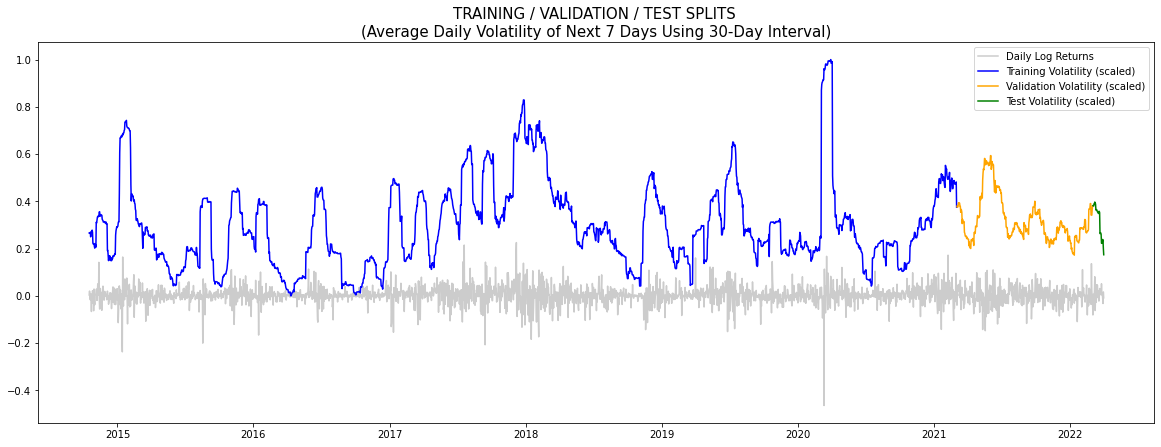

In [ ]:
plt.figure(figsize=(20,7))

plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

plt.plot(y_train_scaled, color='blue', label='Training Volatility (scaled)')
plt.plot(y_val_scaled, color='orange', label='Validation Volatility (scaled)')
plt.plot(y_test_scaled, color='green', label='Test Volatility (scaled)')

plt.plot()
plt.title(f'TRAINING / VALIDATION / TEST SPLITS \n(Average Daily Volatility of Next {n_future} Days Using {WINDOW_SIZE}-Day Interval)', fontsize=15)
plt.legend()
plt.show();

## Baseline Model

This would be a very simple model that only outputs the average current realized volatility of the whole training set as predictions.

In [ ]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.2959317824900293

In [ ]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

In [ ]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    plt.figure(figsize=(20,7))
    plt.plot(y_true, color='blue', 
             label=f"Scaled Next {n_future} days' Daily Volatility (Target)")
    plt.plot(x_val_scaled, color='gray',  ls='--',
             label=f"Scaled Current Daily Volatility")
    plt.plot(lr_val, color='gray', alpha=0.4,
             label='Daily Log Returns')
    plt.plot(y_pred, color='orange', lw=3,
             label=f'Forecasted Volatility')

    plt.title(f'{model_name}', fontsize=15)
    plt.legend(loc='best');

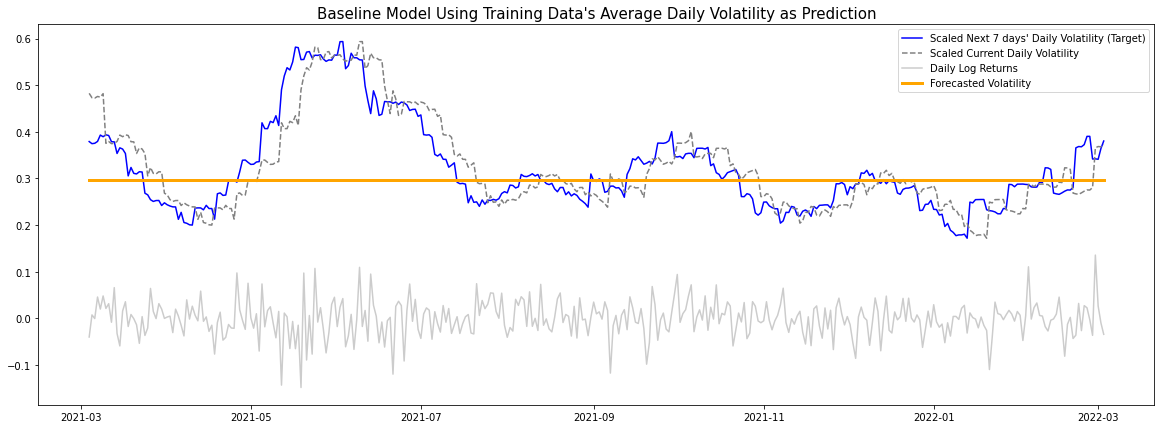

In [ ]:
viz_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")

In [ ]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [ ]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

#### Metrics

The 2 main metrics I'd be using are **RMSPE (Root Mean Squared Percentage Error)** and **RMSE (Root Mean Square Errors)** with RMSPE prioritized. Scaling is very important in the calculation of volatility due to the level of freedom in frequency selection. Therefore I think RMSPE would help capture degree of errors compared to desired target values better than other metrics. Also RMSPE would punish large errors more than regular MAPE (Mean Absolute Percentage Error), which is what I want to do here.

RMSE and RMSPE would be tracked across different models' performance on validation set forecasting to indicate their abilities to generalize on out-of-sample data.

In [ ]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [ ]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [ ]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.248294,0.098241


### Naive Random Walk Forecasting

A commonly known fact about volatility is that it tends to be autocorrelated. This property can be used to implement a naive model that just "predicts" future volatility by using whatever the daily volatility was at the immediate previous time step.

In this case, I'll use the daily volatility of the most recent 7 days as predictions for the next 7 days, which is essentially `vol_current`.

In [ ]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

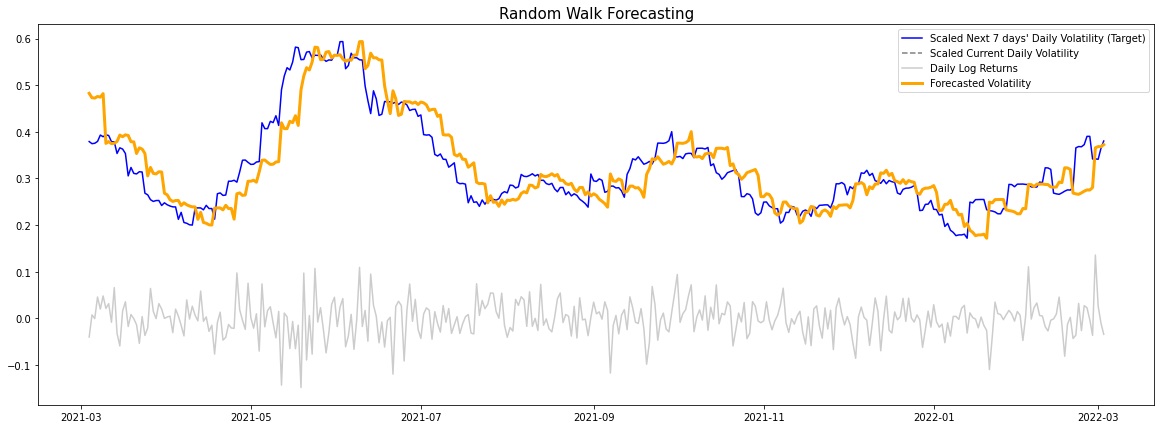

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Forecasting')

In [ ]:
print('Validation RMSPE:', RMSPE(y_val_scaled, random_walk_preds))

Validation RMSPE: 0.14774563251482228


In [ ]:
print('Validation RMSE:', RMSE(y_val_scaled, random_walk_preds))

Validation RMSE: 0.04760780768156078


In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 'Random Walk')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.248294,0.098241
1,Random Walk,0.147746,0.047608


So the both error mertrics have gone down by a decent amount. Naive forecasting in time series is sometimes surprisingly difficult to outperform.

### GARCH Model

(Source: Sinclair)

GARCH Model is the traditional econometric approach to volatility prediction of financial time series.

GARCH(1,1) only contains first-order lagged terms and the mathematic equation for it is: 


$\sigma^2_t = \omega + \alpha\epsilon^{2}_{(t-1)} + \beta\sigma^{2}_{(t-1)}$

where $\alpha$, $\beta$ and $\omega$ sum up to 1, and $\omega$ is the long term variance.

GARCH is generally regarded as an insightful improvement on naively assuming future volatility will be like the past, but also considered widely overrated as predictor by some experts in the field of volatility. GARCH models capture the essential characteristics of volatility: volatility tomorrow will be close to what it is today (**clustering**), and volatility in the long term will probably **mean revert** (meaning it'd be close to whatever the historical long-term average has been).

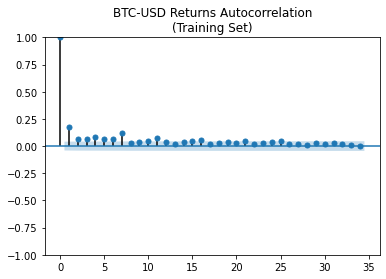

In [ ]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

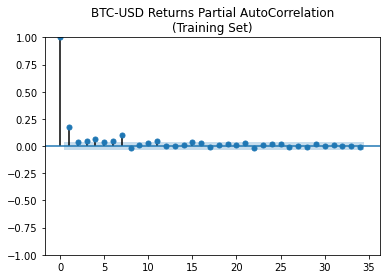

In [ ]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

The autocorrelation plots seem to indicate that there's only significant correlation up to the 7th lags, and the ones following don't seem to be too significant.

GARCH models are trained on percent returns. One of the reasons I decided to normalize the volatilities across the board is because I am still not 100% sure which timeframe/frequency/interval GARCH conditional volatility is calculated in (likely daily), and still haven't figured out why the outputs here seem to be on a totally different scale compared to the volatilities previously calculated. Once I scale them, they match up much more nicely.

In [ ]:
from arch import arch_model

In [ ]:
r_train

Date
2014-10-17    0.314201
2014-10-18    2.002301
2014-10-19   -0.484362
2014-10-20   -1.720205
2014-10-21    0.948166
                ...   
2021-02-27   -0.326520
2021-02-28   -2.274775
2021-03-01    9.955017
2021-03-02   -2.523116
2021-03-03    4.463206
Name: returns, Length: 2330, dtype: float64

In [ ]:
r_val

Date
2021-03-04    -3.912036
2021-03-05     0.753970
2021-03-06    -0.030498
2021-03-07     4.690650
2021-03-08     2.030657
                ...    
2022-02-27    -3.568234
2022-02-28    14.541184
2022-03-01     2.688852
2022-03-02    -0.970630
2022-03-03    -3.351981
Name: returns, Length: 365, dtype: float64

In [ ]:
gm_1 = arch_model(r_train, p=7, q=7,
                  dist='normal')
result_1 = gm_1.fit()
print()
print(result_1.summary())

Iteration:      1,   Func. Count:     18,   Neg. LLF: 6281.509444148991
Iteration:      2,   Func. Count:     38,   Neg. LLF: 6270.915021049149
Iteration:      3,   Func. Count:     58,   Neg. LLF: 6253.308009931871
Iteration:      4,   Func. Count:     77,   Neg. LLF: 6246.087245064662
Iteration:      5,   Func. Count:     98,   Neg. LLF: 6242.303517197822
Iteration:      6,   Func. Count:    117,   Neg. LLF: 6239.802025902576
Iteration:      7,   Func. Count:    136,   Neg. LLF: 6234.370226206825
Iteration:      8,   Func. Count:    155,   Neg. LLF: 6233.133186297891
Iteration:      9,   Func. Count:    174,   Neg. LLF: 6232.12420014151
Iteration:     10,   Func. Count:    194,   Neg. LLF: 6231.91834810742
Iteration:     11,   Func. Count:    213,   Neg. LLF: 6230.016973359398
Iteration:     12,   Func. Count:    232,   Neg. LLF: 6229.097914202206
Iteration:     13,   Func. Count:    252,   Neg. LLF: 6228.948203721063
Iteration:     14,   Func. Count:    271,   Neg. LLF: 6228.4604634

Using a significant level of 0.05, none of the coefficients seems to be statistically significant. Therefore, I'll reduce the values of `p` and `q` to 1 to see if that helps.

In [ ]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1,
                  dist='normal')
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6241.90
Distribution:                  Normal   AIC:                           12491.8
Method:            Maximum Likelihood   BIC:                           12514.8
                                        No. Observations:                 2330
Date:                Sat, Apr 09 2022   Df Residuals:                     2329
Time:                        08:16:24   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2378  6.396e-02      3.719  2.003e-04 [  0.112,  0.3

All coefficients look statistically significant now.

After being fitted to the training data (percent returns), the GARCH model outputs conditional volatility for the training portion of the time series. I am going to scale the fitted conditional volatility arrays, plot it out and compare it to the realized volatility calculated above (also scaled) `x_train_scaled`.

In [ ]:
ans = result_1.forecast(horizon=365)

In [ ]:
len(ans.variance.values[-1,:])

365

In [ ]:
scaler_garch_vol = MinMaxScaler()

cond_vol_arr = result_1.conditional_volatility.values.reshape(-1,1)

# FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
scaler_garch_vol = scaler_garch_vol.fit(cond_vol_arr)
scaled_cond_vol = pd.Series(scaler_garch_vol.transform(cond_vol_arr)[:,0],
                            index=train_idx)

In [ ]:
len(result_1.conditional_volatility.values)

2330

In [ ]:
len(r_val)

365

In [ ]:
resy = RMSPE(r_val,ans.variance.values[-1,:])

In [ ]:
r_val.values

array([-3.91203598e+00,  7.53970166e-01, -3.04980524e-02,  4.69064981e+00,
        2.03065655e+00,  4.93352204e+00,  2.16042438e+00,  3.20767148e+00,
       -8.18320663e-01,  6.82165277e+00, -3.16896104e+00, -5.72510046e+00,
        1.60570219e+00,  3.63699628e+00, -1.71896939e+00,  8.42965014e-01,
       -5.65719046e-02, -1.35512480e+00, -5.20531854e+00,  3.84749812e-01,
       -3.58918075e+00, -2.02770319e+00,  6.63999248e+00,  1.51657595e+00,
       -4.06721399e-02,  3.21613785e+00,  2.02162452e+00,  1.93596350e-03,
        3.00373508e-01,  4.88196901e-01, -2.99813503e+00,  2.00448971e+00,
        5.09413855e-01, -1.46554456e+00, -3.68333901e+00,  4.05898082e+00,
       -1.35363285e-01,  2.65813437e+00,  6.88590395e-01, -5.17418654e-01,
        6.02737648e+00, -6.20063438e-01,  3.23748047e-01, -2.75013794e+00,
       -1.44376885e+00, -7.36215468e+00, -8.75046895e-01,  1.34369761e+00,
       -4.54542876e+00, -3.97694660e+00, -1.29171508e+00, -2.04092898e+00,
       -2.09109920e+00,  

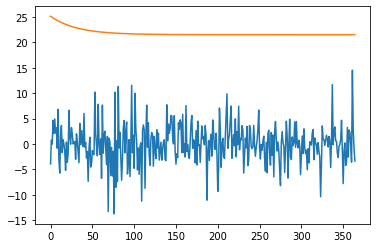

In [ ]:
plt.plot(r_val.values)
plt.plot(ans.variance.values[-1,:])
plt.show()

In [ ]:
result_1.forecast()

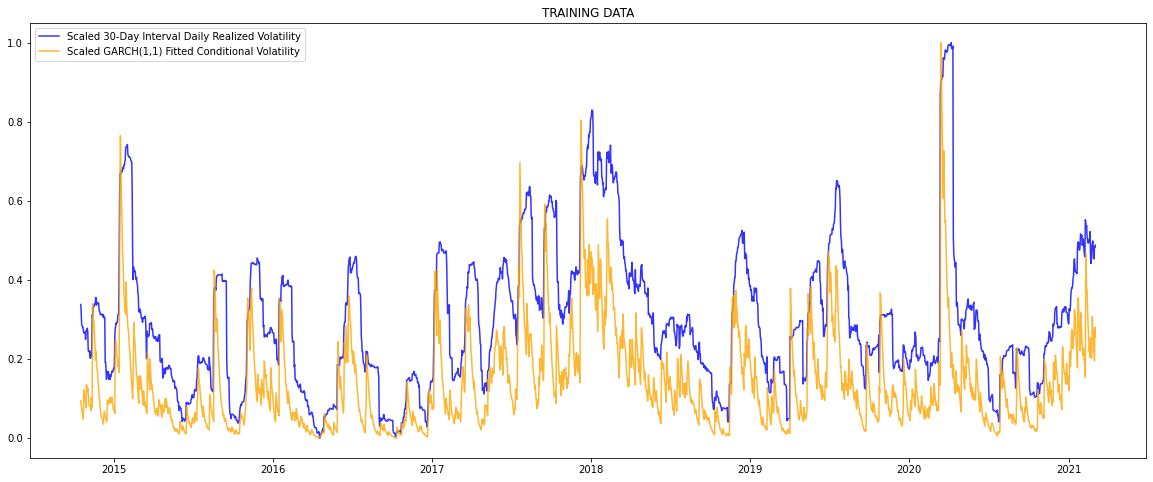

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(x_train_scaled, color='blue', alpha=0.8,
        label=f'Scaled {WINDOW_SIZE}-Day Interval Daily Realized Volatility')
ax.plot(scaled_cond_vol, color='orange', alpha=0.8,
        label='Scaled GARCH(1,1) Fitted Conditional Volatility')
ax.set_title('TRAINING DATA')
plt.legend()
plt.show();

#### Analytical-based Forecasting

The volatility forecasts from the GARCH models using percent returns as input are on a totally different scale compared to the volatilities calculated from log returns. Therefore I am going to normalize the forecasted volatility based on the model's `conditional_volatility` output from the training data, and only comparing the scaled versions of volatilities on the Validation set.

In [ ]:
# ROLLING FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]
    # from_idx = idx[split_time_1 + i - WINDOW_SIZE]
    # to_idx = idx[split_time_1 + i - 1]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # OR FIXED ROLLING WINDOW FITTING
    # model_fit = model.fit(disp='off', first_obs=from_idx, last_obs=to_idx)

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [ ]:
print('Validation RMSE:', RMSPE(y_val_scaled, gm_1_preds))

Validation RMSE: 12.030102888940931


In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = pd.Series(scaler_garch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                              index=val_idx)

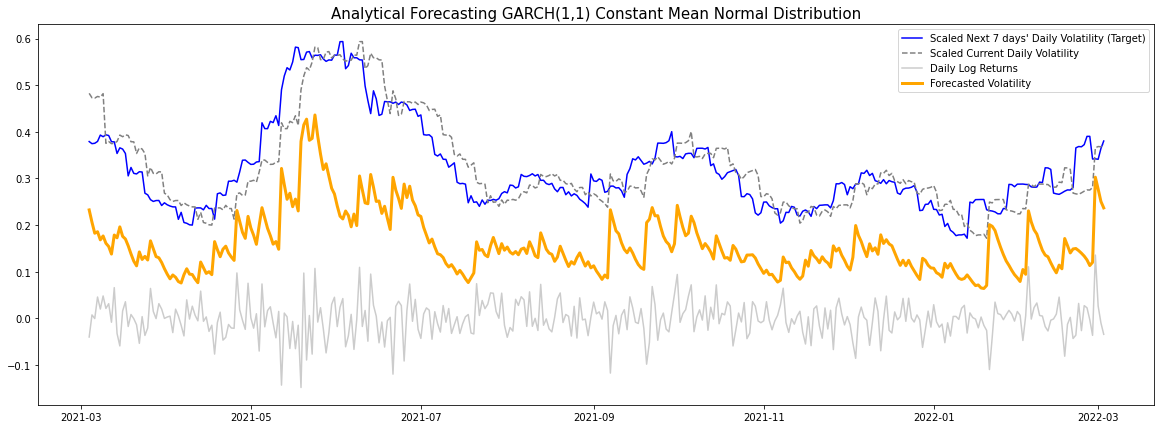

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

So 7-day horizon forecasting is still lagging behind compared to target values. Similar to the training volatilities comparison above, GARCH's forecasted volatility appears to be lower side (after normalization).

In [ ]:
print('Validation RMSPE:', RMSPE(y_val_scaled, gm_1_preds_scaled))

Validation RMSPE: 0.5226330444140677


In [ ]:
print('Validation RMSE:', RMSE(y_val_scaled, gm_1_preds_scaled))

Validation RMSE: 0.17282870928454375


In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 'GARCH(1,1) | Constant Mean | Normal Dist')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.248294,0.098241
1,Random Walk,0.147746,0.047608
2,"GARCH(1,1) | Constant Mean | Normal Dist",0.522633,0.172829


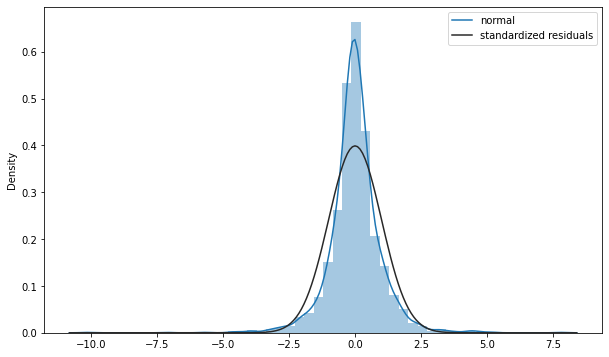

In [ ]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
plt.figure(figsize=(10,6))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
plt.legend(('normal', 'standardized residuals'))
plt.show();

Ref: https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/

"GARCH models make distribution assumptions about the residuals and the mean return. Financial time series data often does not follow a normal distribution. In financial time series it is much more likely to observe extreme positive and negative values that are far away from the mean. to improve a GARCH models distribution assumptions to be more representative of real financial data we can specify the models distribution assumption to be a Student's t-distribution. A Student's t-distribution is symmetric and bell shaped similar to a normal distribution but has fatter tails making it more prone to producing values that fall far away from its mean. The nu  (𝜈)  parameter indicates its shape the larger the  𝜈  the more peaked the curve becomes.

GARCH models enable one to specify the distribution assumptions of the standardized residuals. By default, a normal distribution is assumed, which has a symmetric, bell-shaped probability density curve. Other options include Student's t-distribution and skewed Student's t-distribution."

Looking at the plot above of the standardized residuals, I think I can try skewed Student's T for the next fit.

### GARCH Models with Asymmetric Shocks Responses

The basic GARCH model assumes positive and negative news have similar impact on volatility. However, in reality the market tends to "take the stairs up and the elevator down." In other words, the impact is usually asymmetric, and negative returns tends to affect the volatility more than positive ones.

There's another member in the GARCH family that accounts for assymmetry of shocks reponses called **GJR-GARCH** (short for Glosten-Jagannathan-Runkle GARCH).

Additional inputs can be used to construct other models. In this case, by setting `o` to 1, which means the model would include one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics.


In [ ]:
gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')

In [ ]:
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -5881.24
Distribution:      Standardized Skew Student's t   AIC:                           11776.5
Method:                       Maximum Likelihood   BIC:                           11816.8
                                                   No. Observations:                 2330
Date:                           Sat, Apr 09 2022   Df Residuals:                     2329
Time:                                   08:16:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Log-likelihood has increased quite a bit. Let's see how the conditional volatility looks.

In [ ]:
scaler_gjr_garch_vol = MinMaxScaler()

gjr_cond_vol_arr = result_2.conditional_volatility.values.reshape(-1,1)

# FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
scaler_gjr_garch_vol = scaler_gjr_garch_vol.fit(gjr_cond_vol_arr)
scaled_gjr_cond_vol = pd.Series(scaler_gjr_garch_vol.transform(gjr_cond_vol_arr)[:,0],
                                index=train_idx)

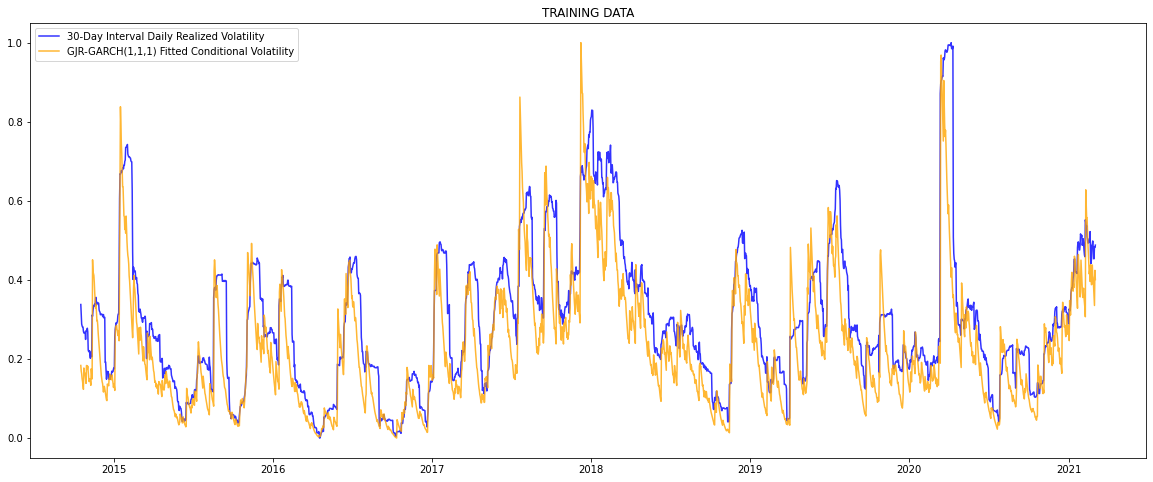

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(x_train_scaled, color='blue', alpha=0.8,
        label=f'{WINDOW_SIZE}-Day Interval Daily Realized Volatility')
ax.plot(scaled_gjr_cond_vol, color='orange', alpha=0.8,
        label='GJR-GARCH(1,1,1) Fitted Conditional Volatility')
ax.set_title('TRAINING DATA')
plt.legend()
plt.show();

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_gm_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_gm_1_preds_scaled = pd.Series(scaler_gjr_garch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                                  index=val_idx)

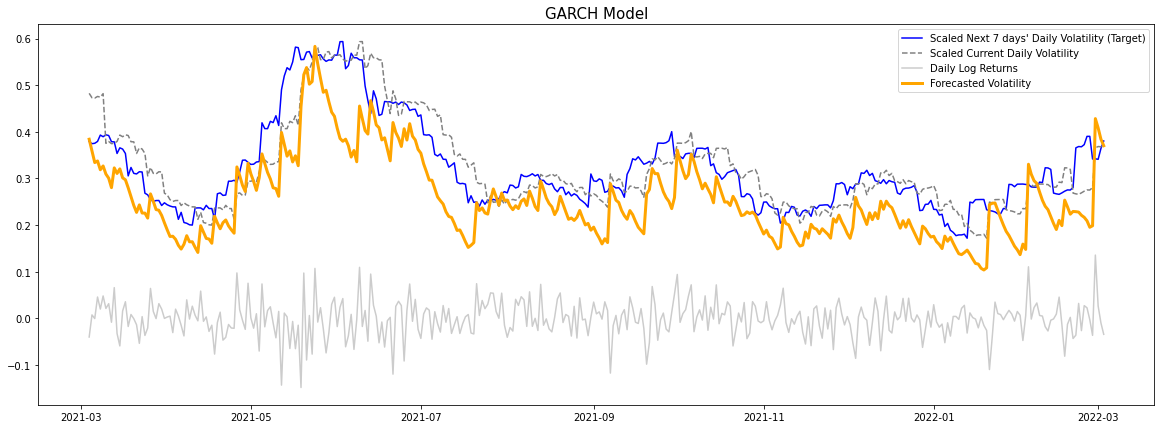

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_gm_1_preds_scaled, 
          "GARCH Model")

In [ ]:
RMSPE(y_val_scaled, gjr_gm_1_preds_scaled)

0.24803240497651394

In [ ]:
RMSE(y_val_scaled, gjr_gm_1_preds_scaled)

0.08331788159043295

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_gm_1_preds_scaled, 
         "Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.248294,0.098241
1,Random Walk,0.147746,0.047608
2,"GARCH(1,1) | Constant Mean | Normal Dist",0.522633,0.172829
3,"Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist",0.248032,0.083318


## Neural Networks

In [ ]:
import tensorflow as tf

In [ ]:
# def windowed_dataset(x_series, y_series, lookback_window, batch_size, shuffle_buffer):
#     # PAST VOLATILITY
#     ds_x = tf.data.Dataset.from_tensor_slices(x_series)
#     ds_x = ds_x.window(lookback_window, shift=1, drop_remainder=True)
#     b_x = ds_x.flat_map(lambda w: w.batch(lookback_window))

#     # LOOK FORWARD VOLATILITY 
#     # SKIPPING FORWARD TO WHERE THE PREDICTION SHOULD START
#     ds_y = tf.data.Dataset.from_tensors(y_series[lookback_window:]).unbatch()
#     b_y = ds_y.batch(1)

#     zipped = tf.data.Dataset.zip((b_x, b_y)).map(lambda x, y: tf.concat((x, y), axis=0))

#     dataset = zipped.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1]))
#     dataset = dataset.batch(batch_size).prefetch(1)

#     return dataset

In [ ]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        from_idx = x_series.index[i-lookback_window+1]
        to_idx = x_series.index[i]
        a = x_series[from_idx:to_idx].values
        dataX.append(a)
        dataY.append(y_series[to_idx])

    return np.array(dataX), np.array(dataY)

In [ ]:
from keras import backend as K

In [ ]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [ ]:
def val_forecast(model):
    forecast = []
    idx = df.index

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(val_idx)):
        # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
        # (including current value)
        from_idx = idx[split_time_1 + i - n_past + 1]
        to_idx = idx[split_time_1 + i]
        pred = model.predict(df.vol_current[from_idx:to_idx].values[np.newaxis])
        forecast.append(pred)

    forecast = np.array(forecast)[:, 0, 0]
    preds = pd.Series(forecast, index=val_idx)

    preds_scaled = pd.Series(scaler_vol.transform(preds.values.reshape(-1,1))[:,0],
                                index=val_idx)
    return preds_scaled

In [ ]:
def viz_train_val_metrics(model_hist):
    fig, ax = plt.subplots(figsize=(20,8))

    # PLOT MSE - LEFT Y-AXIS
    # TRAINING
    ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['loss'], color='lightblue',
                label='Training MSE')
    # VALIDATION
    ln12 = ax.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['val_loss'], color='darkblue',
                label='Validation MSE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')

    # PLOT RMSE - RIGHT Y-AXIS
    ax2 = ax.twinx()
    ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['rmspe'], color='pink',
                label='Training RMSPE')
    ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['val_rmspe'], color='red',
                label='Validation RMSPE')
    ax2.set_ylabel('RMSPE')

    # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
    lns = ln11 + ln12 + ln21 + ln22
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best')

    ax.set_title('Training vs. Validation Metrics', fontsize=15)
    plt.show();

### Neural Network Baseline Metrics - Fully Connected Network

This is essentially Linear Regression.

(Training directly using scaled volatility produces `inf` RMSPE, so I'll stick with the original volatility, and scale the forecasts later).

In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# FIT MODEL TO TRAINING DATASET
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100, verbose=1,
                      validation_data=(mat_X_val, mat_y_val),
                      batch_size=batch_size, shuffle=True)

Epoch 1/100
36/36 [==============================] - 1s 6ms/step - loss: 1.8457e-04 - rmspe: 0.4112 - val_loss: 6.1756e-05 - val_rmspe: 0.1894
Epoch 2/100
36/36 [==============================] - 0s 2ms/step - loss: 1.2338e-04 - rmspe: 0.3456 - val_loss: 4.1589e-05 - val_rmspe: 0.1659
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 9.1831e-05 - rmspe: 0.3141 - val_loss: 3.2226e-05 - val_rmspe: 0.1426
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 7.6105e-05 - rmspe: 0.2841 - val_loss: 2.5998e-05 - val_rmspe: 0.1329
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 6.9295e-05 - rmspe: 0.2687 - val_loss: 2.3131e-05 - val_rmspe: 0.1333
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 6.7644e-05 - rmspe: 0.2600 - val_loss: 2.1594e-05 - val_rmspe: 0.1288
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 6.8474e-05 - rmspe: 0.2619 - val_loss: 2.0934e-05 - val_rmspe: 0.1272

In [ ]:
snn_1_preds_scaled = val_forecast(snn_1)

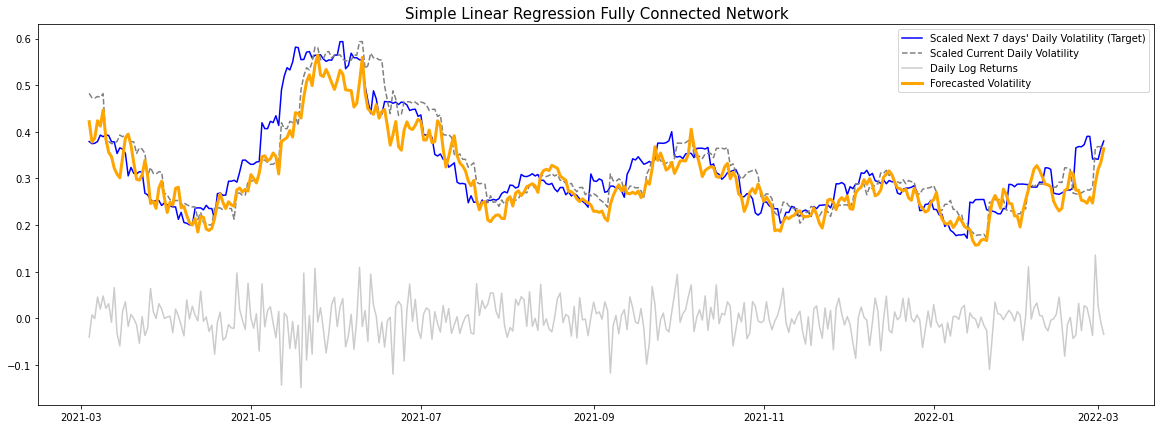

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, snn_1_preds_scaled, 
          "Simple Linear Regression Fully Connected Network")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN | n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.248294,0.098241
1,Random Walk,0.147746,0.047608
2,"GARCH(1,1) | Constant Mean | Normal Dist",0.522633,0.172829
3,"Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist",0.248032,0.083318
4,Simple LR Fully Connected NN | n_past=30,0.136593,0.046988


A simple Fully Connected NN doesn't perform too bad. Validation RMSPE after 100 epochs of training and barely any tuning is only a bit higher than best GARCH model found, and RMSE is also lower. The forecast actually syncs up with the current volatility, and a bit behind the target that I want.

### Long Short-Term Memory (LSTM) - Univariate

Source: Hands-on Machine Learning... - A. Geron

LSTM is a black box, and can be used like a basic Recurrent Neural Network (RNN) cell. However, it tends to perform much better, helps training converge faster, and also detect long-term dependencies in the data.

At first, I'm going to use the same lookback window `n_past` as the previous Neural Networks (14), and then depending on the result, I'll try to fine tune that value later.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from decimal import Decimal

In [ ]:
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=50,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
36/36 [==============================] - 3s 29ms/step - loss: 4.9428e-04 - rmspe: 0.8342 - val_loss: 8.8460e-05 - val_rmspe: 0.1780
Epoch 2/200
36/36 [==============================] - 1s 15ms/step - loss: 2.3381e-04 - rmspe: 0.6786 - val_loss: 5.5605e-05 - val_rmspe: 0.1612
Epoch 3/200
36/36 [==============================] - 1s 14ms/step - loss: 1.6060e-04 - rmspe: 0.4951 - val_loss: 4.1591e-05 - val_rmspe: 0.1494
Epoch 4/200
36/36 [==============================] - 1s 14ms/step - loss: 1.3666e-04 - rmspe: 0.4047 - val_loss: 4.2315e-05 - val_rmspe: 0.1731
Epoch 5/200
36/36 [==============================] - 1s 14ms/step - loss: 1.2595e-04 - rmspe: 0.4017 - val_loss: 3.4622e-05 - val_rmspe: 0.1346
Epoch 6/200
36/36 [==============================] - 1s 16ms/step - loss: 1.1229e-04 - rmspe: 0.3555 - val_loss: 2.8217e-05 - val_rmspe: 0.1344
Epoch 7/200
36/36 [==============================] - 0s 14ms/step - loss: 1.0152e-04 - rmspe: 0.3456 - val_loss: 2.4168e-05 - val_rmspe:

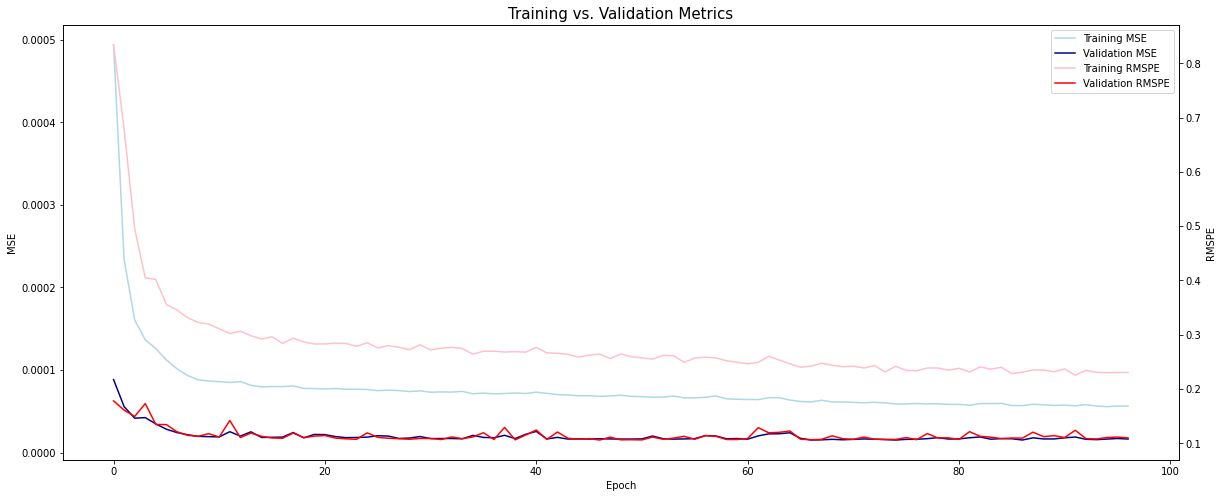

In [ ]:
viz_train_val_metrics(lstm_1_res)

Although both lines look pretty unstable, overall there's a downward trend.

#### Forecasting on the Validation set

In [ ]:
lstm_1_preds_scaled = val_forecast(lstm_1)

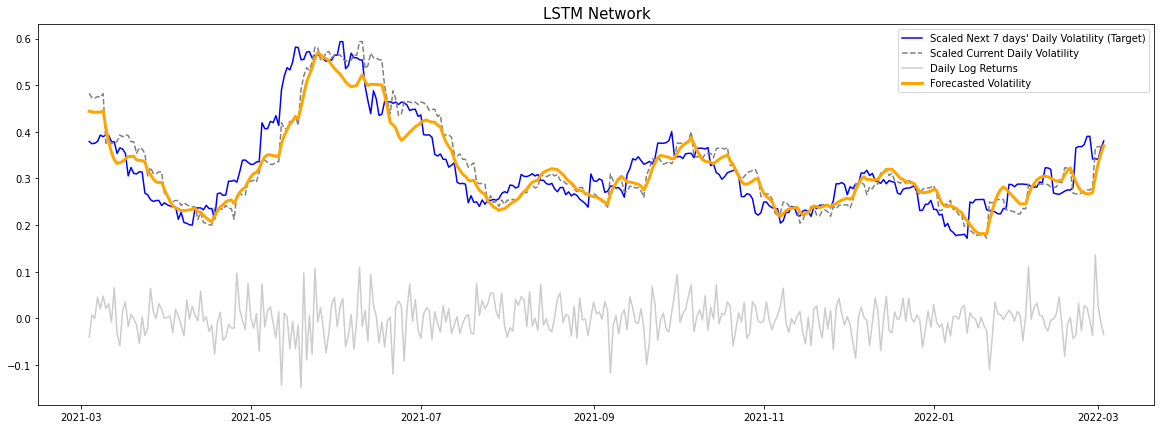

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"LSTM Network")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units | n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.248294,0.098241
1,Random Walk,0.147746,0.047608
2,"GARCH(1,1) | Constant Mean | Normal Dist",0.522633,0.172829
3,"Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist",0.248032,0.083318
4,Simple LR Fully Connected NN | n_past=30,0.136593,0.046988
5,LSTM 1 layer 20 units | n_past=30,0.127415,0.042322


The performance of the 1 layered LSTM networks with 20 is getting close to the Random Walk model (which is still the best one so far in terms of RMSPE unfortunately). 

(Source: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs%20are%20an%20extension,LSTMs%20on%20the%20input%20sequence)

Further research shows that there's an extension of LSTM cell called **Bidirectional LSTM**, which could potentially be better in this case by providing additional context to the models. "In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem." 

I'll also increase the number of hidden layers to see if the model can capture certain patterns better.

In [ ]:
tf.keras.backend.clear_session()

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
37/37 [==============================] - 10s 69ms/step - loss: 2.8692e-04 - rmspe: 0.6376 - val_loss: 4.0462e-05 - val_rmspe: 0.1633
Epoch 2/200
37/37 [==============================] - 1s 23ms/step - loss: 1.2644e-04 - rmspe: 0.3720 - val_loss: 4.0470e-05 - val_rmspe: 0.1687
Epoch 3/200
37/37 [==============================] - 1s 24ms/step - loss: 1.1554e-04 - rmspe: 0.3554 - val_loss: 3.1668e-05 - val_rmspe: 0.1347
Epoch 4/200
37/37 [==============================] - 1s 24ms/step - loss: 1.0589e-04 - rmspe: 0.3306 - val_loss: 3.5759e-05 - val_rmspe: 0.1630
Epoch 5/200
37/37 [==============================] - 1s 23ms/step - loss: 9.5124e-05 - rmspe: 0.3218 - val_loss: 2.4704e-05 - val_rmspe: 0.1197
Epoch 6/200
37/37 [==============================] - 1s 23ms/step - loss: 8.7559e-05 - rmspe: 0.3033 - val_loss: 2.1165e-05 - val_rmspe: 0.1116
Epoch 7/200
37/37 [==============================] - 1s 23ms/step - loss: 8.2233e-05 - rmspe: 0.2866 - val_loss: 6.3898e-05 - val_rmspe

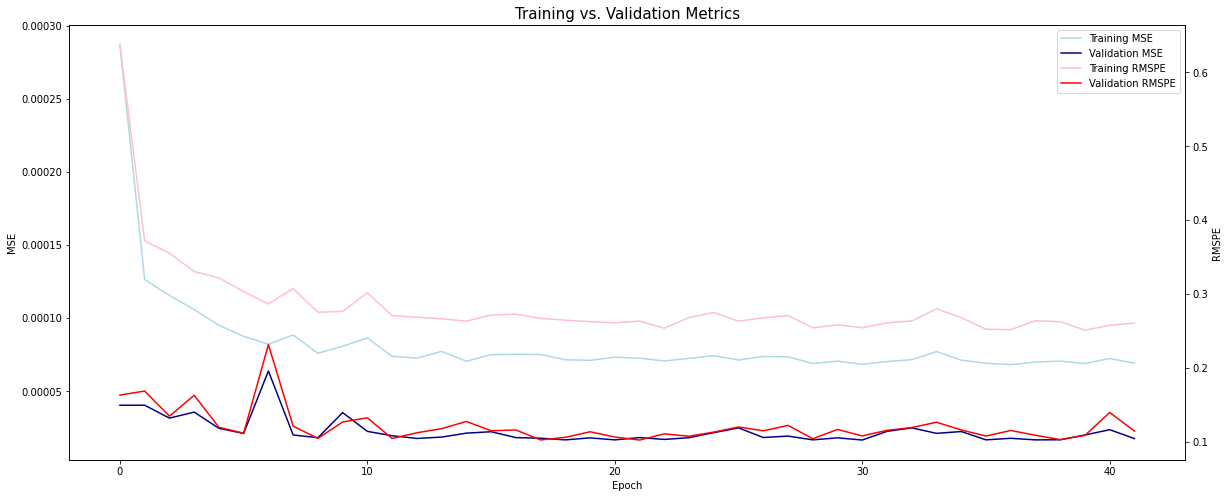

In [ ]:
viz_train_val_metrics(lstm_2_res)

In [ ]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_2_preds_scaled = val_forecast(lstm_2)

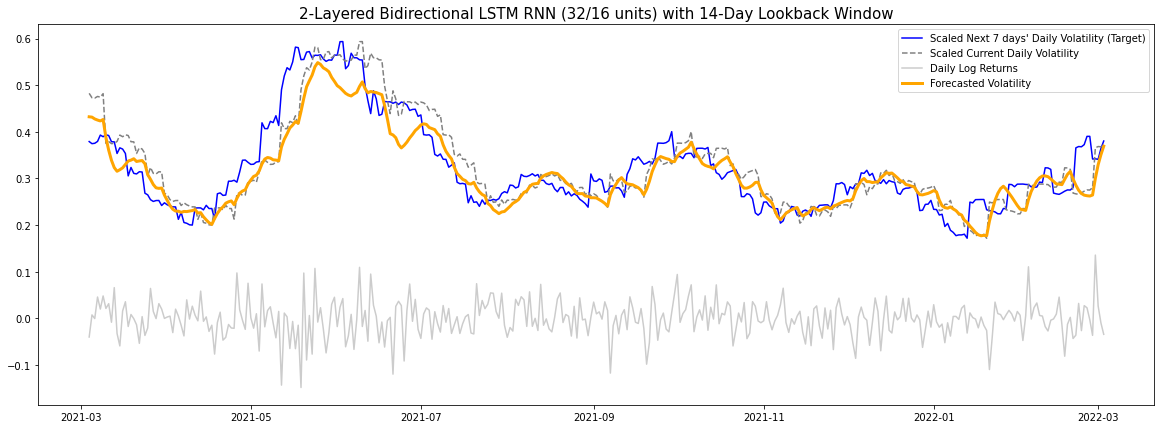

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTM RNN (32/16 units) with {n_past}-Day Lookback Window")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units) | n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.248294,0.098241
1,Random Walk,0.147746,0.047608
2,"GARCH(1,1) | Constant Mean | Normal Dist",0.522633,0.172829
3,"Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist",0.248032,0.083318
4,Simple LR Fully Connected NN | n_past=30,0.136593,0.046988
5,LSTM 1 layer 20 units | n_past=30,0.127415,0.042322
6,2 layers Bidirect LSTM (32/16 units) | n_past=14,0.126801,0.044296


#### Increasing Lookback Window & Number of Hidden LSTM Layers

I also want to experiment with other activation functions because the target input cannot be negative --> need to look more into that.


In [ ]:
tf.keras.backend.clear_session()

# INCREASING LOOK BACK WINDOW TO 1 month
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
36/36 [==============================] - 7s 64ms/step - loss: 3.7998e-04 - rmspe: 0.7185 - val_loss: 6.6924e-05 - val_rmspe: 0.1815
Epoch 2/200
36/36 [==============================] - 2s 45ms/step - loss: 2.0013e-04 - rmspe: 0.5733 - val_loss: 6.1847e-05 - val_rmspe: 0.1632
Epoch 3/200
36/36 [==============================] - 2s 44ms/step - loss: 1.5151e-04 - rmspe: 0.4230 - val_loss: 4.4806e-05 - val_rmspe: 0.1698
Epoch 4/200
36/36 [==============================] - 2s 44ms/step - loss: 1.3391e-04 - rmspe: 0.3926 - val_loss: 5.2242e-05 - val_rmspe: 0.1982
Epoch 5/200
36/36 [==============================] - 2s 45ms/step - loss: 1.1826e-04 - rmspe: 0.3687 - val_loss: 2.9449e-05 - val_rmspe: 0.1376
Epoch 6/200
36/36 [==============================] - 2s 43ms/step - loss: 1.0686e-04 - rmspe: 0.3451 - val_loss: 4.0157e-05 - val_rmspe: 0.1810
Epoch 7/200
36/36 [==============================] - 2s 45ms/step - loss: 9.7550e-05 - rmspe: 0.3330 - val_loss: 2.0412e-05 - val_rmspe:

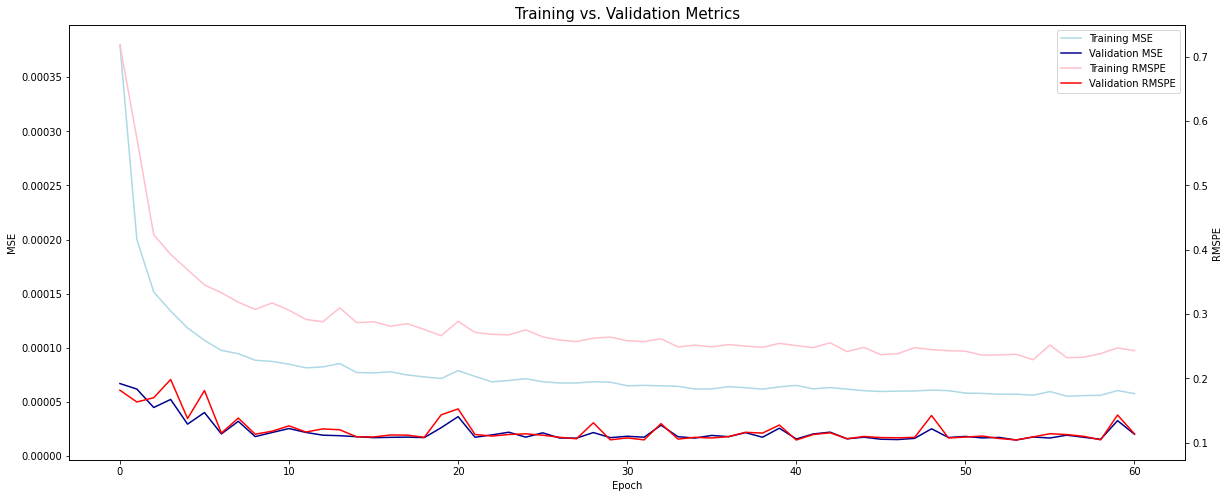

In [ ]:
viz_train_val_metrics(lstm_3_res)

In [ ]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_3_preds_scaled = val_forecast(lstm_3)

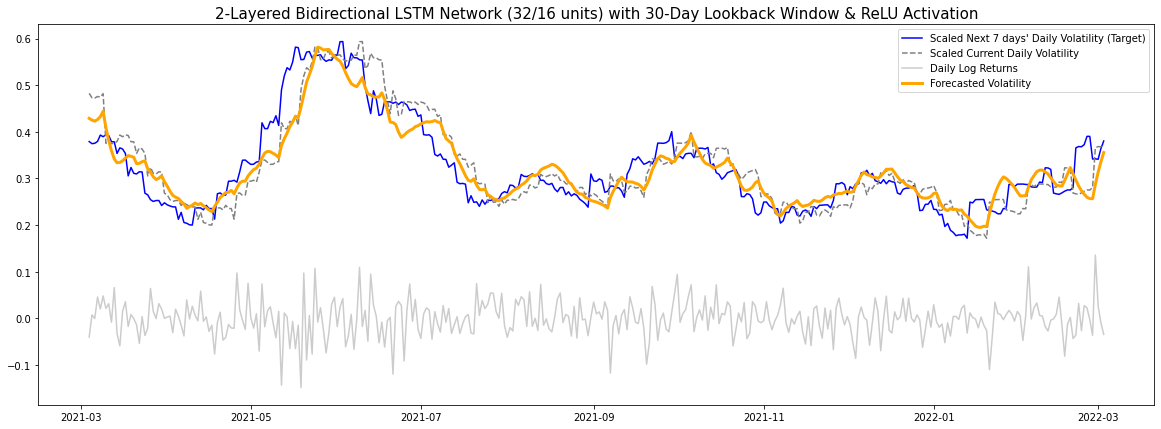

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_3_preds_scaled, 
          f"2-Layered Bidirectional LSTM Network (32/16 units) with {n_past}-Day Lookback Window & ReLU Activation")

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled, 
         f"Bidirectional LSTM 2 layers 32/16 units | n_past={n_past} | act=relu")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.248294,0.098241
1,Random Walk,0.147746,0.047608
2,"GARCH(1,1) | Constant Mean | Normal Dist",0.522633,0.172829
3,"Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist",0.248032,0.083318
4,Simple LR Fully Connected NN | n_past=30,0.136593,0.046988
5,LSTM 1 layer 20 units | n_past=30,0.127415,0.042322
6,2 layers Bidirect LSTM (32/16 units) | n_past=14,0.126801,0.044296
7,Bidirectional LSTM 2 layers 32/16 units | n_past=30 | act=relu,0.124908,0.041054


Overall the results for this model are a bit better than GARCH models.

I want to keep extending look back window to see where is the furthest I can go without smoothing out the prediction line too much. From further research I found out that 1D Convolultional Layers can also be added to the NN structure to help learn both short-term and long-term patterns more efficiently.